In [1]:
import random
import numpy as np
import pandas as pd
from scipy import stats
import pycaret
import gower
# import umap
import umap.umap_ as umap
from sklearn.neighbors import DistanceMetric
from pycaret.clustering import *
from category_encoders.backward_difference import BackwardDifferenceEncoder
from transformers import RobertaForMaskedLM, RobertaTokenizer, pipeline
from category_encoders import HelmertEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import gridspec
import matplotlib.pyplot as plt
import plotnine as p9
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## 1 ML задача

Тебе даны данные HTTP запросов. 

Глобальная задача — найти или разделить вредоносные от хороших. Как мы знаем, вредоносных классов может быть несколько. 

Важнее отделить «мух от котлет». 

Попробуй сделать EDA, понять, а точно ли данные не избыточны и всё, что ты вообще можешь сказать?!

В ходе решения этой части ожидаем, что будут предоставлены артефакты (например jupyter notebook) с экспериментами, которые помогут понять, почему принято решение использовать такой подход к задаче.

## 2 Сервис для inference 
https://heyiamsasha.notion.site/ML-PT-0bc4ce5012604ed397f040a1bdc29858

- Подсказка 1
    
    Классов может быть до 50, но не обязательно 50
    
- Подсказка 2
    
    Кластеризация очень помогает
    
- Подсказка 3
    
    Да, типично что у нас нет числа классов. Но что делать, это жизнь? Мы для базового решения использовали DBSCAN, может быть и ты можешь начать с него?
    
- Подсказка 4
    
    посмотри на поля, точно ли все они нужны?

In [2]:
dataset = pd.read_csv('../data/part_10.csv')
# classified = classified_source.copy()
dataset.sample()

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
33544,217.175.140.69,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,3728,200,REQUEST_GET_ARGS,REQUEST_GET_ARGS.s,50d11ff31f5a0d00362137a3c0d951d6072746ce,oXP-HmQB5cBXmMW1wIxC


<AxesSubplot: >

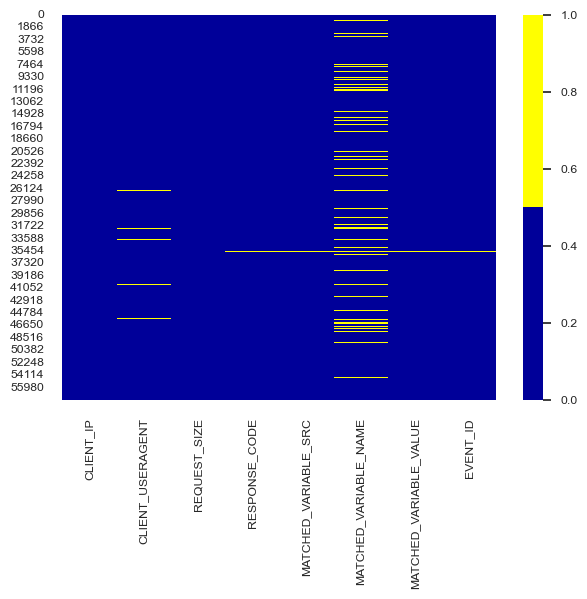

In [3]:
# пропущенные значения
colours = ['#000099', '#ffff00'] 
sns.set(rc={'figure.figsize':(7,5)})
sns.set(font_scale=0.8)
sns.heatmap(dataset.isnull(), cmap=sns.color_palette(colours))

In [4]:
dataset = dataset[~dataset.isnull().all(1)]

for col in dataset.columns:
    pct_missing = np.mean(dataset[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

CLIENT_IP - 0%
CLIENT_USERAGENT - 1%
REQUEST_SIZE - 0%
RESPONSE_CODE - 0%
MATCHED_VARIABLE_SRC - 0%
MATCHED_VARIABLE_NAME - 8%
MATCHED_VARIABLE_VALUE - 0%
EVENT_ID - 0%


In [5]:
# выбросы
# https://proglib.io/p/moem-dataset-rukovodstvo-po-ochistke-dannyh-v-python-2020-03-27

In [6]:
# TODO: удалить строки - полные дубликаты 

### ДУБЛИКАТЫ  -- ОТСАВИТЬ!!

In [7]:
dataset[dataset.duplicated(keep=False)]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
4144,f~|°ØÀ¶ g8%ú·P:V­,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11506,¿b_,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11804,f~|°ØÀ¶ g8%ú·P:V­,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18615,f~|°ØÀ¶ g8%ú·P:V­,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20342,f~|°ØÀ¶ g8%ú·P:V­,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25760,f~|°ØÀ¶ g8%ú·P:V­,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31594,¢×˾û8äyªû¬Aü,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38144,¿b_,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43187,¢×˾û8äyªû¬Aü,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
dataset = dataset.drop(index=dataset[dataset.duplicated(keep=False)].index)

In [9]:
# что с этим делать?
key = ['CLIENT_USERAGENT',	'RESPONSE_CODE',	'MATCHED_VARIABLE_SRC',	'MATCHED_VARIABLE_NAME',
       'MATCHED_VARIABLE_VALUE',]
dataset[key][dataset[key].duplicated(keep=False)]

,CLIENT_USERAGENT,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE
27,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,200,REQUEST_GET_ARGS,REQUEST_GET_ARGS.q,"{\""tags\"":[{\""sizes\"":[{\""width\"":728,\""height..."
1922,NaN,NaN,NaN,NaN,NaN
2552,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,200,REQUEST_POST_ARGS,©æ(4È,NaN
3231,NaN,NaN,NaN,NaN,NaN
3371,curl/7.22.0 (i686-pc-linux-gnu) libcurl/7.22.0...,200,REQUEST_POST_ARGS,©æ(4È,NaN
3671,NaN,NaN,NaN,NaN,NaN
6242,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,200,REQUEST_GET_ARGS,REQUEST_GET_ARGS.q,"{\""tags\"":[{\""sizes\"":[{\""width\"":728,\""height..."
6437,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,200,REQUEST_GET_ARGS,REQUEST_GET_ARGS.q,"{\""tags\"":[{\""sizes\"":[{\""width\"":728,\""height..."
7664,NaN,NaN,NaN,NaN,NaN
8035,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,200,REQUEST_GET_ARGS,REQUEST_GET_ARGS.q,"{\""tags\"":[{\""sizes\"":[{\""width\"":728,\""height..."


In [10]:
print('всего CLIENT_IP ', len(dataset['CLIENT_IP'].value_counts().keys()))

print('уникальных CLIENT_IP ', len(set(dataset['CLIENT_IP'].value_counts().keys())))

print('всего EVENT_ID ', len(dataset['EVENT_ID'].value_counts().keys()))

print('уникальных EVENT_ID ', len(set(dataset['EVENT_ID'].value_counts().keys())))

print('всего в датасете записей ', len(dataset))

всего CLIENT_IP  24937
уникальных CLIENT_IP  24937
всего EVENT_ID  54410
уникальных EVENT_ID  54410
всего в датасете записей  57829


In [11]:
# посмотреть на дублирующие EVENT_ID

In [12]:
# REQUEST_SIZE, RESPONSE_CODE в int?

In [13]:
# TODO: кодировки поменять?

### CLIENT_USERAGENT

In [14]:
rndm = 3337
for i in range(rndm,(rndm+6)):
    print(dataset.loc[i, 'CLIENT_USERAGENT'])
    print()

Mozilla/5.0 (compatible; YandexBot/3.0; +http://yandex.com/bots)

Mozilla/5.0 (Linux; Android 7.0; LG-M200 Build/NRD90U) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.137 Mobile Safari/537.36

Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.101 Safari/537.36

Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36

Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_2 like Mac OS X) AppleWebKit/604.4.7 (KHTML, like Gecko) Version/11.0 Mobile/15C202 Safari/604.1

Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11



### MATCHED_VARIABLE_NAME, MATCHED_VARIABLE_VALUE

In [15]:
dataset[['MATCHED_VARIABLE_SRC', 'MATCHED_VARIABLE_NAME', 'MATCHED_VARIABLE_VALUE' ]].sample(10)

,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE
23601,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,1516515020128
20267,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,464945053
10706,REQUEST_GET_ARGS,page,smennye-filtruyuschie-elementy-dlya-filtrov-to...
13450,REQUEST_ARGS,action,verificationcode;vid=register;rand=496c2b682ac...
18601,REQUEST_COOKIES,REQUEST_COOKIES._cc_cc,"\""ACZ4nMXWWU8TURQH8CnWmChLWD6AzyYmoEUgvml8Mz75..."
32436,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,260518115
12879,REQUEST_GET_ARGS,REQUEST_GET_ARGS._,140951022
31418,REQUEST_GET_ARGS,REQUEST_GET_ARGS.rid,3509075723
35208,REQUEST_GET_ARGS,LINK,http://www.uralexpo.ru/vystavki/109/
46166,REQUEST_XML,/xml/query_info/query,select count(*) from `u50548_pravoved`.`36_pag...


In [16]:
len(dataset['MATCHED_VARIABLE_NAME'].value_counts().keys()), len(dataset['MATCHED_VARIABLE_VALUE'].value_counts().keys())

(3209, 57611)

In [17]:
dataset['MATCHED_VARIABLE_NAME'].value_counts()[-3:]

srchPat%255B4%255D                                                 1
/content/goods/item[25]:Comment                                    1
XâO½#*«
WÒ:©¹µMÖ\täÛk17qòmʂ3³vާÏ?æÞÅË
Ëî<èMkq,,ÜÆì½8    1
Name: MATCHED_VARIABLE_NAME, dtype: int64

### MATCHED_VARIABLE_SRC

In [18]:
dataset['MATCHED_VARIABLE_SRC'].value_counts()

REQUEST_GET_ARGS                    20812
REQUEST_COOKIES                      9303
REQUEST_HEADERS                      4930
REQUEST_PATH                         4011
REQUEST_ARGS                         3729
RESPONSE_HEADERS                     3364
REQUEST_POST_ARGS                    3304
REQUEST_URI                          3143
REQUEST_XML                          1959
REQUEST_METHOD\';\'REQUEST_CONTE      812
REQUEST_URI\';\'REQUEST_ARGS          666
REQUEST_ARGS_KEYS                     639
REQUEST_JSON                          587
REQUEST_METHOD\';\'REQUEST_HEADE      227
CLIENT_USERAGENT                      133
CLIENT_SESSION_ID                      42
REQUEST_QUERY                          35
RESPONSE_BODY                          22
REQUEST_CONTENT_TYPE                    6
REQUEST_FILES                           5
CLIENT_IP                               1
Name: MATCHED_VARIABLE_SRC, dtype: int64

In [19]:
dataset[dataset['MATCHED_VARIABLE_SRC'] == 'REQUEST_FILES'].sample(5)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
8543,109.195.49.179,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,159543,200,REQUEST_FILES,reference to,http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd,AVdqyNGwq1Ppo9zF-M6B
15121,37.209.206.246,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,968,301,REQUEST_FILES,file,<?php eval(base64_decode(c3lzdGVtKGJhc2U2NF9kZ...,QTDhNWYBrgKk_RFN4OnO
47482,108.179.199.10,Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US...,8884,301,REQUEST_FILES,file,Neko.php\\x0\\x0\\x0\\x0\\x0\\x0\\x0\\x0\\x0\\...,6jV3NmYBrgKk_RFNxhTc
20569,96.44.128.250,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,612,404,REQUEST_FILES,Filedata,8D9AAEEC4D8E4439299046B8CDB3F782<?php @eval($...,ejHrNWYBrgKk_RFNsDI6
15659,203.162.127.193,Mozilla 15,1049,404,REQUEST_FILES,module,PK\n\\x0\\x0\\x0\\x0\\x0RanIjðýU1\\x0\\x0\\x...,wUvZGmQB5cBXmMW1VuHM


In [20]:
### комбинированные признаки

In [21]:
# признак MATCHED_VARIABLE_NAME	== MATCHED_VARIABLE_VALUE	
dataset['var_name_eql_value'] = np.where(dataset['MATCHED_VARIABLE_NAME'] == dataset['MATCHED_VARIABLE_VALUE'], 1, 0 )
dataset['var_name_eql_value'].value_counts()

0    57252
1      577
Name: var_name_eql_value, dtype: int64

In [22]:
np.unique(dataset[dataset['var_name_eql_value'] == 1]['MATCHED_VARIABLE_SRC'])

array(['REQUEST_ARGS', 'REQUEST_ARGS_KEYS', 'REQUEST_GET_ARGS'],
      dtype=object)

In [23]:
# TODO: вытаскивать из CLIENT_USERAGENT curl, linux, mozilla 

In [24]:
# проверка, что MATCHED_VARIABLE_SRC в MATCHED_VARIABLE_NAME
dataset['variable_src_in_name'] = dataset.apply(lambda x: str(x.MATCHED_VARIABLE_SRC) in str(x.MATCHED_VARIABLE_NAME), axis=1) * 1
dataset['variable_src_in_name'].value_counts()

1    41938
0    15891
Name: variable_src_in_name, dtype: int64

In [25]:
dataset[dataset['variable_src_in_name'] == 0].sample(3)

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,var_name_eql_value,variable_src_in_name
24400,178.137.18.202,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,481,200,REQUEST_ARGS,action,verificationcode;vid=register;rand=34fdcc8768f...,AVdXGSSrq1Ppo9zFzgVb,0,0
13710,217.69.134.63,Mozilla/5.0 (compatible; Linux x86_64; Mail.RU...,442,200,REQUEST_URI,NaN,/sitemap-pt-adress-2014-07.xml,AVdWuzs6q1Ppo9zFzPbK,0,0
17719,185.5.140.253,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,752,301,REQUEST_URI\';\'REQUEST_ARGS,query,/Content/Images/Common?query=%5C..%5CWEB-INF%5...,NrMIEmQBoRd31uenFi_v,0,0


### REQUEST_SIZE

In [26]:
dataset['REQUEST_SIZE'] = pd.to_numeric(dataset['REQUEST_SIZE'], errors='coerce')
dataset.loc[50, 'REQUEST_SIZE']

nan

In [27]:
dataset['bad_req_size'] = np.where(dataset['REQUEST_SIZE'].isna(), 1, 0)

In [28]:
# не удалять, а добавлять новый признак 
dataset[dataset['REQUEST_SIZE'].isna()][:3]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,var_name_eql_value,variable_src_in_name,bad_req_size
50,"> -gOxT""O<Ghèe]Ø È8 G`Qf¾ñ }y ðù!T...",SQL Injection,NaN,2f53b17df6da6bf9aeec27b0d87413c4,NaN,NaN,NaN,NaN,0,1,1
162,Remote Code Execution,AVdtgf8uq1Ppo9zF_hyd,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1
1308,"~@.*"")ۅ",SQL Injection,NaN,dd7ff149a6270e8037f6aa280b4ca1bd,NaN,NaN,NaN,NaN,0,1,1


In [29]:
dataset['REQUEST_SIZE'].fillna(-1, inplace=True)
dataset['REQUEST_SIZE'] = dataset['REQUEST_SIZE'].astype('int')

### RESPONSE_CODE

In [30]:
dataset['RESPONSE_CODE'].value_counts()[:1]

200    25771
Name: RESPONSE_CODE, dtype: int64

In [31]:
dataset['RESPONSE_CODE'].value_counts()[-3:]

82b4c42ac7edc647d27de21ceb791491    1
429                                 1
7ccc451ad8a2981f1e6f7eb6a5813246    1
Name: RESPONSE_CODE, dtype: int64

In [32]:
dataset['RESPONSE_CODE'] = pd.to_numeric(dataset['RESPONSE_CODE'], errors='coerce')
dataset['bad_resp_code'] = np.where(dataset['RESPONSE_CODE'].isna(), 1, 0)
dataset[dataset['RESPONSE_CODE'].isna()][:3]

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,var_name_eql_value,variable_src_in_name,bad_req_size,bad_resp_code
50,"> -gOxT""O<Ghèe]Ø È8 G`Qf¾ñ }y ðù!T...",SQL Injection,-1,NaN,NaN,NaN,NaN,NaN,0,1,1,1
162,Remote Code Execution,AVdtgf8uq1Ppo9zF_hyd,-1,NaN,NaN,NaN,NaN,NaN,0,1,1,1
1308,"~@.*"")ۅ",SQL Injection,-1,NaN,NaN,NaN,NaN,NaN,0,1,1,1


In [33]:
dataset['RESPONSE_CODE'].fillna(-1, inplace=True)
dataset['RESPONSE_CODE'] = dataset['RESPONSE_CODE'].astype('int')

In [34]:
### UUID?

In [35]:
cat_features = list(dataset.loc[:, dataset.dtypes == object].columns)

num_features = list(set(dataset.columns).difference(set(cat_features)))



In [36]:
# TODO: признак по апишке 
cat_features.remove('CLIENT_IP')

In [37]:
dataset[cat_features].sample()

,CLIENT_USERAGENT,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
6146,DirBuster-1.0-RC1 (http://www.owasp.org/index....,REQUEST_PATH,REQUEST_PATH,/v3.php,qro5_mMBjksgoq1eIu19


In [38]:
tokenizer = RobertaTokenizer.from_pretrained('sberbank-ai/ruRoberta-large')

def get_token(x):
    """возвращает эмбеддинг текста"""
    return tokenizer(x, add_special_tokens=False)['input_ids']

dataset['random_feature'] = random.sample(range(1, len(dataset) + 1), len(dataset))

In [39]:
# TODO: как-то обрабаывать List[str] и List[List[str]] ?
for col in cat_features:
    dataset[col] = dataset[col].astype('str')

In [40]:
# CLIENT_USERAGENT и MATCHED_VARIABLE_VALUE долго обрабатываются 
text_cols = cat_features[1:]

In [41]:
%%time
for col in text_cols:
    if col != text_cols[-1]:
        print(col, ' -->')
    dataset[col + '_median'] = dataset[col].apply(lambda x: np.median(get_token(x)))
    dataset[col + '_sum'] = dataset[col].apply(lambda x: np.sum(get_token(x)))
    dataset[col + '_mean'] = dataset[col].apply(lambda x: np.mean(get_token(x)))
    dataset[col + '_mode'] = dataset[col].apply(lambda x: stats.mode(get_token(x)).mode[0])
    dataset[col + '_min'] = dataset[col].apply(lambda x: np.min(get_token(x)))
    dataset[col + '_max'] = dataset[col].apply(lambda x: np.max(get_token(x)))
    dataset[col + '_std'] = dataset[col].apply(lambda x: np.std(get_token(x)))

MATCHED_VARIABLE_SRC  -->
MATCHED_VARIABLE_NAME  -->
MATCHED_VARIABLE_VALUE  -->
CPU times: user 3min 20s, sys: 268 ms, total: 3min 20s
Wall time: 3min 21s


In [42]:
for col in cat_features:
    dataset[col + '_count'] = dataset[col].map(dataset.groupby(col).size())

In [43]:
num_features = list(set(dataset.columns).difference(set(cat_features)))
num_features.append('CLIENT_IP')
len(num_features)

42

In [44]:
dataset[num_features].to_csv('embeddings.csv', index=False)